In [ ]:
pip install plotly

In [ ]:
pip install psycopg2

In [1]:

import numpy as np
import pandas as pd
# import pandas.io.sql as sqlio 
import psycopg2 
from sqlalchemy import create_engine
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph 
from IPython.display import Image
from IPython.core.display import SVG
import matplotlib.pyplot as plt
# import folium
from matplotlib.ticker import MaxNLocator
import json
from sklearn.manifold import TSNE
import seaborn as sns
#tree map
import plotly.express as px

%matplotlib inline

# CO2 Emission by Sector

In [2]:
# Load Emission dataset 
emission_by_sector_df = pd.read_csv("data/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv", encoding="latin-1")

In [11]:
#Inspect data
emission_by_sector_df

,Area,Item,Element,Year,Unit,Value
0,Afghanistan,"Energy (energy, manufacturing and construction...",Emissions (CO2eq),1990,Gigagrams,943.2945
1,Afghanistan,"Energy (energy, manufacturing and construction...",Emissions (CO2eq),1991,Gigagrams,1022.1110
2,Afghanistan,"Energy (energy, manufacturing and construction...",Emissions (CO2eq),1992,Gigagrams,542.7868
3,Afghanistan,"Energy (energy, manufacturing and construction...",Emissions (CO2eq),1993,Gigagrams,548.8871
4,Afghanistan,"Energy (energy, manufacturing and construction...",Emissions (CO2eq),1994,Gigagrams,537.9067
...,...,...,...,...,...,...
820387,OECD,Sources total excl. AFOLU,Share of F-gases in sector emissions,2006,Gigagrams,2.9732
820388,OECD,Sources total excl. AFOLU,Share of F-gases in sector emissions,2007,Gigagrams,3.1445
820389,OECD,Sources total excl. AFOLU,Share of F-gases in sector emissions,2008,Gigagrams,3.4143
820390,OECD,Sources total excl. AFOLU,Share of F-gases in sector emissions,2009,Gigagrams,3.9743


In [4]:
#For loop to get column names for emission df
for col in emission_by_sector_df.columns:
    print(col)

Area Code
Area
Item Code
Item
Element Code
Element
Year Code
Year
Unit
Value
Flag


In [5]:
#Drop column names to keep columns of interest
emission_by_sector_df.drop(["Area Code", "Item Code", "Element Code", "Year Code", "Flag"], axis=1, inplace=True )

In [6]:
#For loop to get reduced column names for emission df
for col in emission_by_sector_df.columns:
    print(col)

Area
Item
Element
Year
Unit
Value


In [7]:
#dtype for DB schema
emission_by_sector_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820392 entries, 0 to 820391
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Area     820392 non-null  object 
 1   Item     820392 non-null  object 
 2   Element  820392 non-null  object 
 3   Year     820392 non-null  int64  
 4   Unit     820392 non-null  object 
 5   Value    820392 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 37.6+ MB


In [16]:
emission_by_sector_reduced = emission_by_sector_df[emission_by_sector_df['Area'] == 'OECD']
emission_by_sector_reduced.head(5)

,Area,Item,Element,Year,Unit,Value
816948,OECD,"Energy (energy, manufacturing and construction...",Emissions (CO2eq),1990,Gigagrams,6.970622e+06
816949,OECD,"Energy (energy, manufacturing and construction...",Emissions (CO2eq),1991,Gigagrams,6.944881e+06
816950,OECD,"Energy (energy, manufacturing and construction...",Emissions (CO2eq),1992,Gigagrams,6.978787e+06
816951,OECD,"Energy (energy, manufacturing and construction...",Emissions (CO2eq),1993,Gigagrams,7.122402e+06
816952,OECD,"Energy (energy, manufacturing and construction...",Emissions (CO2eq),1994,Gigagrams,7.261234e+06


## Export to CSV

In [18]:
emission_by_sector_reduced.to_csv('emission_by_sector_final.csv')

## Connect & Load into Database

In [9]:

db_server_info = {"host": "localhost", 
                  "port": 5432, 
                  "dbname": "ghg_emissions", 
                  "user": "postgres", 
                  "password": "postgres"} 
conn_str = "{}://{}:{}@{}:{}/{}".format(
                                  "postgresql+psycopg2", 
                                  db_server_info["user"], 
                                  db_server_info["password"], 
                                  db_server_info["host"], 
                                  db_server_info["port"], 
                                  db_server_info["dbname"]) 
alchemyEngine = create_engine(conn_str, pool_recycle=3600)
postgreSQLConnection = alchemyEngine.connect() 

In [19]:
# df to DB table
emission_by_sector_reduced.to_sql("Emissions_by_Sector", postgreSQLConnection, index=False, if_exists='append')

# Emissions Produced From Agriculture Sector

In [20]:
# Load Agriculture emmisions dataset
agriculture_emissions_df = pd.read_csv("data/Emissions_Agriculture_Agriculture_total_E_All_Data_(Normalized).csv", encoding='latin-1')

In [21]:
agriculture_emissions_df

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note
0,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),1961,1961,gigagrams,240.6831,A,NaN
1,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),1962,1962,gigagrams,245.3106,A,NaN
2,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),1963,1963,gigagrams,255.8285,A,NaN
3,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),1964,1964,gigagrams,259.0650,A,NaN
4,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),1965,1965,gigagrams,265.5980,A,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
517650,5873,OECD,1709,Agricultural Soils,7243,Emissions (CO2eq) from N2O,2015,2015,gigagrams,507990.0946,A,NaN
517651,5873,OECD,1709,Agricultural Soils,7243,Emissions (CO2eq) from N2O,2016,2016,gigagrams,512816.3450,A,NaN
517652,5873,OECD,1709,Agricultural Soils,7243,Emissions (CO2eq) from N2O,2017,2017,gigagrams,511843.1916,A,NaN
517653,5873,OECD,1709,Agricultural Soils,7243,Emissions (CO2eq) from N2O,2030,2030,gigagrams,523814.1026,A,NaN


In [22]:
#For loop to get column names for emission df
for col in agriculture_emissions_df.columns:
    print(col)

Area Code
Area
Item Code
Item
Element Code
Element
Year Code
Year
Unit
Value
Flag
Note


In [23]:
#Drop unnecessary columns
agriculture_emissions_df.drop(["Area Code", "Item Code", "Element Code", "Year Code", "Flag", "Note"], axis=1, inplace=True )

In [24]:
#For loop to get updated column names
for col in agriculture_emissions_df.columns:
    print(col)

Area
Item
Element
Year
Unit
Value


## Connect & Load Into Database

In [25]:
db_server_info = {"host": "localhost", 
                  "port": 5432, 
                  "dbname": "ghg_emissions", 
                  "user": "postgres", 
                  "password": "postgres"} 
conn_str = "{}://{}:{}@{}:{}/{}".format(
                                  "postgresql+psycopg2", 
                                  db_server_info["user"], 
                                  db_server_info["password"], 
                                  db_server_info["host"], 
                                  db_server_info["port"], 
                                  db_server_info["dbname"]) 
alchemyEngine = create_engine(conn_str, pool_recycle=3600)
postgreSQLConnection = alchemyEngine.connect() 

In [26]:
# df to DB table
agriculture_emissions_df.to_sql("Emissions_from_Agriculture", postgreSQLConnection, index=False, if_exists='append')

In [27]:
#Loop through the columns of argiculture_emissions_df
for col in agriculture_emissions_df.columns:
    print(col)

Area
Item
Element
Year
Unit
Value


As explained on https://ecometrica.com/assets/GHGs-CO2-CO2e-and-Carbon-What-Do-These-Mean-v2.1.pdf,

# Carbon dioxide
Carbon dioxide (CO2) is the most common GHG emitted by human activities, in terms of the quantity
released and the total impact on global warming.  As a result the term “CO2” is sometimes used as a
shorthand expression for all greenhouse gases, however, this can cause confusion, and a more
accurate way of referring to a number of GHGs collectively is to use the term “carbon dioxide
equivalent” or “CO2e” (explained below).  
Because CO2 is considered the most important greenhouse gas some GHG assessments or reports
only include CO2, and don’t consider the other greenhouse gases, and this can lead to an
understatement of total global warming impact.  Greenhouse gas inventories are more complete if
they include all GHGs and not just CO2.


# Carbon dioxide equivalent (CO2e)
“Carbon dioxide equivalent” or “CO2e” is a term for describing different greenhouse gases in a
common unit.  For any quantity and type of greenhouse gas, CO2e signifies the amount of CO2 which
would have the equivalent global warming impact.




In [28]:
# Extract into a dataframe values of agriculture CO2, CO2eq emissions
world_agriculture_emissions = agriculture_emissions_df[(agriculture_emissions_df.Area=='World') 
                                                       & ~(agriculture_emissions_df.Element.isin(['Emissions (CO2eq)']))
                                                       & (agriculture_emissions_df.Item=='Agriculture total')
                                                       & (agriculture_emissions_df.Year<2020)]

In [30]:
# Extract list of years and gas types for plot below
xticks = world_agriculture_emissions.Year.drop_duplicates().sort_values().values
labels = world_agriculture_emissions.Element.drop_duplicates().values

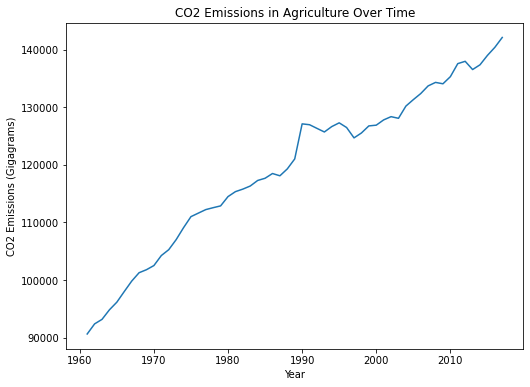

In [31]:
# Plot nominal and per capita CO2eq world agricultural emissions over time 
fig = plt.figure(figsize=(18,6))
p1 = fig.add_subplot(121)
p1.plot(xticks, world_agriculture_emissions[world_agriculture_emissions.Element==labels[0]].Value.values)
p1.set_xlabel('Year')
p1.set_ylabel('CO2 Emissions (Gigagrams)')
p1.set_title('CO2 Emissions in Agriculture Over Time')
plt.show()

# Greenhouse Gas Contributors

In [32]:
# world_agriculture_emissions.to_csv('world_agriculture_emissions.csv')

In [33]:
#Import data
ghg_contributor_df = pd.read_csv("data/Food_Production.csv")

In [34]:
#Explore dataset and look at first 10 results
print(ghg_contributor_df.info())
ghg_contributor_df.head(n=10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 23 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   Food product                                                             43 non-null     object 
 1   Land use change                                                          43 non-null     float64
 2   Animal Feed                                                              43 non-null     float64
 3   Farm                                                                     43 non-null     float64
 4   Processing                                                               43 non-null     float64
 5   Transport                                                                43 non-null     float64
 6   Packging                                                                 43 

,Food product,Land use change,Animal Feed,Farm,Processing,Transport,Packging,Retail,Total_emissions,Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal),...,Freshwater withdrawals per 100g protein (liters per 100g protein),Freshwater withdrawals per kilogram (liters per kilogram),Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal),Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein),Land use per 1000kcal (m² per 1000kcal),Land use per kilogram (m² per kilogram),Land use per 100g protein (m² per 100g protein),Scarcity-weighted water use per kilogram (liters per kilogram),Scarcity-weighted water use per 100g protein (liters per 100g protein),Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories)
0,Wheat & Rye (Bread),0.1,0.0,0.8,0.2,0.1,0.1,0.1,1.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Maize (Meal),0.3,0.0,0.5,0.1,0.1,0.1,0.0,1.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Barley (Beer),0.0,0.0,0.2,0.1,0.0,0.5,0.3,1.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oatmeal,0.0,0.0,1.4,0.0,0.1,0.1,0.0,1.6,4.281357,...,371.076923,482.4,0.945482,1.907692,2.897446,7.60,5.846154,18786.2,14450.92308,7162.104461
4,Rice,0.0,0.0,3.6,0.1,0.1,0.1,0.1,4.0,9.514379,...,3166.760563,2248.4,1.207271,6.267606,0.759631,2.80,3.943662,49576.3,69825.77465,13449.891480
5,Potatoes,0.0,0.0,0.2,0.0,0.1,0.0,0.0,0.3,4.754098,...,347.647059,59.1,0.628415,2.705882,1.202186,0.88,5.176471,2754.2,16201.17647,3762.568306
6,Cassava,0.6,0.0,0.2,0.0,0.1,0.0,0.0,0.9,0.708419,...,NaN,0.0,1.355236,14.666667,1.858316,1.81,20.111111,0.0,NaN,NaN
7,Cane Sugar,1.2,0.0,0.5,0.0,0.8,0.1,0.0,2.6,4.820513,...,NaN,620.1,0.911681,NaN,0.581197,2.04,NaN,16438.6,NaN,4683.361823
8,Beet Sugar,0.0,0.0,0.5,0.2,0.6,0.1,0.0,1.4,1.541311,...,NaN,217.7,0.515670,NaN,0.521368,1.83,NaN,9493.3,NaN,2704.643875
9,Other Pulses,0.0,0.0,1.1,0.0,0.1,0.4,0.0,1.6,5.008798,...,203.503036,435.7,0.524927,0.836058,4.565982,15.57,7.272303,22477.4,10498.55208,NaN


In [35]:
ghg_contributor_df.rename(columns={"Food product": "Food_product", "Land use change": "Land_use_change", "Animal Feed": "Animal_feed", "Eutrophying emissions per 1000kcal" : "Eutro_emissions_per1000kcal",
                                  "Eutrophying emissions per kilogram (gPO₄eq per kilogram)" : "Eutro_emissions_perkilo", "Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein)":"Eutro_emissions_per100g", "Freshwater withdrawals per 1000kcal (liters per 1000kcal)": "Freshwater_per_1000kcal", "Freshwater withdrawals per 100g protein (liters per 100g protein)"
                                  : "Fresh_water_per100g", "Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein)": "GHG_emissins_per100g", "Land use per 1000kcal (m² per 1000kcal)" : "Land_use_per1000kcal",
                                  "Land use per kilogram (m² per kilogram)" : "Land_use_perkilog", "Land use per 100g protein (m² per 100g protein)": "Land_use_per100g",
                                  "Scarcity-weighted water use per kilogram (liters per kilogram)": "Weight_water_use_perkilo", "Scarcity-weighted water use per 100g protein (liters per 100g protein)":
                                  "Weight_water_use_per100g", "Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories)":
                                  "Weight_water_use_per1000kcal"})

,Food_product,Land_use_change,Animal_feed,Farm,Processing,Transport,Packging,Retail,Total_emissions,Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal),...,Fresh_water_per100g,Freshwater withdrawals per kilogram (liters per kilogram),Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal),GHG_emissins_per100g,Land_use_per1000kcal,Land_use_perkilog,Land_use_per100g,Weight_water_use_perkilo,Weight_water_use_per100g,Weight_water_use_per1000kcal
0,Wheat & Rye (Bread),0.1,0.0,0.8,0.2,0.1,0.1,0.1,1.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Maize (Meal),0.3,0.0,0.5,0.1,0.1,0.1,0.0,1.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Barley (Beer),0.0,0.0,0.2,0.1,0.0,0.5,0.3,1.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oatmeal,0.0,0.0,1.4,0.0,0.1,0.1,0.0,1.6,4.281357,...,371.076923,482.4,0.945482,1.907692,2.897446,7.60,5.846154,18786.2,14450.923080,7162.104461
4,Rice,0.0,0.0,3.6,0.1,0.1,0.1,0.1,4.0,9.514379,...,3166.760563,2248.4,1.207271,6.267606,0.759631,2.80,3.943662,49576.3,69825.774650,13449.891480
5,Potatoes,0.0,0.0,0.2,0.0,0.1,0.0,0.0,0.3,4.754098,...,347.647059,59.1,0.628415,2.705882,1.202186,0.88,5.176471,2754.2,16201.176470,3762.568306
6,Cassava,0.6,0.0,0.2,0.0,0.1,0.0,0.0,0.9,0.708419,...,NaN,0.0,1.355236,14.666667,1.858316,1.81,20.111111,0.0,NaN,NaN
7,Cane Sugar,1.2,0.0,0.5,0.0,0.8,0.1,0.0,2.6,4.820513,...,NaN,620.1,0.911681,NaN,0.581197,2.04,NaN,16438.6,NaN,4683.361823
8,Beet Sugar,0.0,0.0,0.5,0.2,0.6,0.1,0.0,1.4,1.541311,...,NaN,217.7,0.515670,NaN,0.521368,1.83,NaN,9493.3,NaN,2704.643875
9,Other Pulses,0.0,0.0,1.1,0.0,0.1,0.4,0.0,1.6,5.008798,...,203.503036,435.7,0.524927,0.836058,4.565982,15.57,7.272303,22477.4,10498.552080,NaN


In [36]:
#For loop to get column names 
for col in ghg_contributor_df.columns:
    print(col)

Food product
Land use change
Animal Feed
Farm
Processing
Transport
Packging
Retail
Total_emissions
Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal)
Eutrophying emissions per kilogram (gPO₄eq per kilogram)
Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein)
Freshwater withdrawals per 1000kcal (liters per 1000kcal)
Freshwater withdrawals per 100g protein (liters per 100g protein)
Freshwater withdrawals per kilogram (liters per kilogram)
Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal)
Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein)
Land use per 1000kcal (m² per 1000kcal)
Land use per kilogram (m² per kilogram)
Land use per 100g protein (m² per 100g protein)
Scarcity-weighted water use per kilogram (liters per kilogram)
Scarcity-weighted water use per 100g protein (liters per 100g protein)
Scarcity-weighted water use per 1000kcal (liters per 1000 kilocalories)


In [37]:
#Format columns
for col in ghg_contributor_df.columns:
    pct_missing = np.mean(ghg_contributor_df[col].isnull())
    print('{} - {}%' .format(col, pct_missing))

Food product - 0.0%
Land use change - 0.0%
Animal Feed - 0.0%
Farm - 0.0%
Processing - 0.0%
Transport - 0.0%
Packging - 0.0%
Retail - 0.0%
Total_emissions - 0.0%
Eutrophying emissions per 1000kcal (gPO₄eq per 1000kcal) - 0.23255813953488372%
Eutrophying emissions per kilogram (gPO₄eq per kilogram) - 0.11627906976744186%
Eutrophying emissions per 100g protein (gPO₄eq per 100 grams protein) - 0.37209302325581395%
Freshwater withdrawals per 1000kcal (liters per 1000kcal) - 0.3023255813953488%
Freshwater withdrawals per 100g protein (liters per 100g protein) - 0.3953488372093023%
Freshwater withdrawals per kilogram (liters per kilogram) - 0.11627906976744186%
Greenhouse gas emissions per 1000kcal (kgCO₂eq per 1000kcal) - 0.23255813953488372%
Greenhouse gas emissions per 100g protein (kgCO₂eq per 100g protein) - 0.37209302325581395%
Land use per 1000kcal (m² per 1000kcal) - 0.23255813953488372%
Land use per kilogram (m² per kilogram) - 0.11627906976744186%
Land use per 100g protein (m² per 

In [ ]:
#sort data
Q1_sorted= ghg_contributor_df.sort_values(by = 'Total_emissions', ascending=True)
#subset dataset
plotdata= Q1_sorted.iloc[:,0:9]

In [ ]:
# #Tree map 
# fig = px.treemap(ghg_contributor_df, path=['Food product'],
#                  values='Total_emissions',
#                  color='Total_emissions' )
# fig.update_traces(textinfo="label + value")
# fig.show()

In [ ]:
# #Stacked Bar Chart
# #change size of the figure [width, height]
# plt.rcParams['figure.figsize'] = [15, 20]
# #Create style base on seaborm
# sns.set()
# plotdata.plot(x = 'Food product', y= ['Land use change', 'Animal Feed', 'Farm', 'Processing','Transport', 'Packging', 'Retail'], kind='barh', stacked=True)
# plt.ylabel('Kilogram (kg) of Consumed Food ')
# plt.xlabel('Kg CO2e')
# plt.title('Full Lifecycle Greenhouse Gas Emissions from Common Proteins and Vegetables')
# #custom legend location 
# plt.legend(loc=0)
# plt.show()

In [ ]:
ghg_contributor_df.to_csv('ghg_contributor.csv')

In [ ]:
db_server_info = {"host": "localhost", 
                  "port": 5432, 
                  "dbname": "ghg_emissions", 
                  "user": "postgres", 
                  "password": "postgres"} 
conn_str = "{}://{}:{}@{}:{}/{}".format(
                                  "postgresql+psycopg2", 
                                  db_server_info["user"], 
                                  db_server_info["password"], 
                                  db_server_info["host"], 
                                  db_server_info["port"], 
                                  db_server_info["dbname"]) 
alchemyEngine = create_engine(conn_str, pool_recycle=3600)
postgreSQLConnection = alchemyEngine.connect() 

In [ ]:
# df to DB table
ghg_contributor_df.to_sql("GHG", postgreSQLConnection, index=False, if_exists='append')

In [ ]:
filesname=os.listdir("<path or empty") # Or you can alternately use glob inside `with` ZipFile
# Empty means working folder 

with ZipFile('output.zip', 'w') as myzip:
    for file in files:
        if file.endswith(".csv") 
            myzip.write(file)